In [1]:
import torch
import numpy as np
from torch import nn
import torch.utils.data as data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
REPO_NAME = "2022-2023-DGM-MIPT-course"
!if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
!git clone https://github.com/r-isachenko/{REPO_NAME}.git
!cd {REPO_NAME}
!pip install ./{REPO_NAME}/homeworks/
!rm -Rf {REPO_NAME}

In [4]:
from dgm_utils import train_model, plot_training_curves
from dgm_utils import show_samples, visualize_images, load_pickle

In [5]:
!gdown --id 1hExV0C8wQWsrA4HfRTq9y9rMo7Pjd9Gw

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1hExV0C8wQWsrA4HfRTq9y9rMo7Pjd9Gw
To: /content/mnist.pkl
100% 188M/188M [00:01<00:00, 133MB/s]


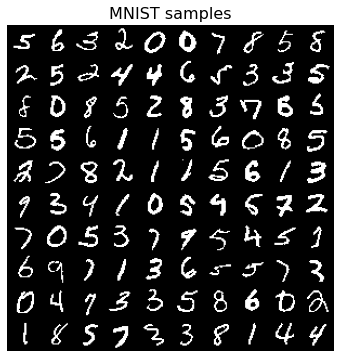

In [6]:
train_data, test_data = load_pickle('/content/mnist.pkl', flatten=False, binarize=True)
# train_data, test_data = load_pickle('./mnist.pkl', flatten=False, binarize=True)
visualize_images(train_data, 'MNIST samples')

In [7]:
train_data.shape

(50000, 1, 28, 28)

Так как предполагается, что на вход модели будет подоваться $(batch\_size, sequence\_length)$, то сразу преобразуем данные, чтобы дальше было удобнее работать

In [8]:
train_data = train_data.astype(np.compat.long).reshape((train_data.shape[0], -1))
test_data = test_data.astype(np.compat.long).reshape((test_data.shape[0], -1))

## ImageGPT

Предполагается реализовать следующую архитектуру авторегрессионной модели основанной на механизме внимания. Далее будет Кратко сказано про каждый блок, после чего приведен код реализации

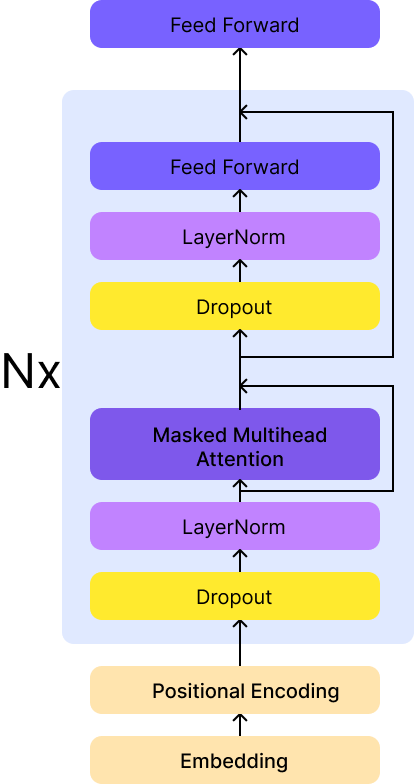

Давайте более подробно рассмотрим из чего состоит ImageGPT.
Как мы уже говорили, архитектурно ImageGPT представляет из себя GPT2, который до перестановки блоков наследует архитектуру декодера в архитектуре Transformer.

Так как мы уже поговорил о том, что из себя представляет Positional Encoding, далее речь пойдет о 
1. Получение эмбеддингов
2. Masked MultiHeadAttention (MMHA).
3. Dropout
4. LayerNorm

### Embeddings

Изначально, что на вход ImageGPT подается некоторая последовательность размера $s$, каждому члену которого соответствует некоторый вектор $x \in \mathbb{R^{dim\_emb}}$. Размерность $dim\_emb$ в дальнейшем будет играть роль, ведь преобразования внутри нашей архитектуры будут учитывать эту размерность.

Поэтому изначально, мы, при помощи класса torch.nn.Embedding генерируем случайным образом тензор с векторами, размера $vocab×dim\_emb$, где $vocab$ - количество дискретных значений, которые мы хотим отобразить в наше непрерывное пространство (конкретно в нашем случае - все возможные значения пикселей, то есть $vocab= 2$).

То есть torch.nn.Embedding cтроит некоторую биективную функцию:

$$
nn.Embedding(vocab, dim\_emb): (vocab, dim\_emb) → f
$$
$$
f(p) : p \in \{0,..., n\} → X \in \mathbb{R^{dim\_emb}}
$$ 

Если эти векторные представления для каждого пикселя уже откуда-то есть, то стоит учитывать это в архитектуре.


После этого векторы переходят в блок **Positional Encoding**.


###Positional Encoding

$$
PE_{(pos, i)} = 
\left\{
\begin{array}{ll}
      sin(\frac{pos}{10000^{\frac{i}{2d}}}), & i = 2k \\
      cos(\frac{pos}{10000^{\frac{i}{2d}}}), & i = 2k+1\\
\end{array} 
\right., 
$$
где $d$ - размерность вектора на входе в модель, $pos$ - позиция вектора в последовательности, а $i$ - координата конкретного значения вектора.

Сам по себе Positional Encoding нам нужен будет для того, чтобы модель имела некоторую информацию том в каком месте в последовательности располагается тот или иной вектор, представляющий конкретный пиксель. Т.к. место элемента в последовательности довольно важно даже при работе с изображениями.

In [9]:
import matplotlib.pyplot as plt
import seaborn

In [10]:
class PositionalEncoding(nn.Module):
  '''
  Модель, реализующая механизм Positional Encoding.
  Args:
    d_model - размер эмбеддинга для элемента последовательности
    max_len - максимальная длина последовательности
  '''
  def __init__(self, d_model, max_len = 785):
    super().__init__()
    self.d_model = d_model
    
    indeces = torch.pow(10000, -1*torch.arange(0, d_model) / (2*d_model))[None,:]
    pos = torch.arange(max_len, dtype = torch.float)[:, None]
    self.pe = pos @ indeces

    self.pe[:, ::2] = torch.sin(self.pe[:, ::2])
    self.pe[:, 1::2] = torch.cos(self.pe[:, 1::2])


  '''
  
  Args:
    embeddings - тензор, содержащий информативное векторное представление о 
    последовательности, который имеет размер (batch_size, sequence_length, d_model)
  Return:
    Тензор такого же размера как и входной (т.е. (batch_size, sequence_length, d_model)), 
    каждый элемент которого (относительно батча) содержит информацию о номере в 
    последовательности данного элемента.
  '''
  def forward(self, embeddings):
    assert len(embeddings.shape) == 3
    embeddings += self.pe[:embeddings.shape[-2]].to(embeddings.device)
    return embeddings

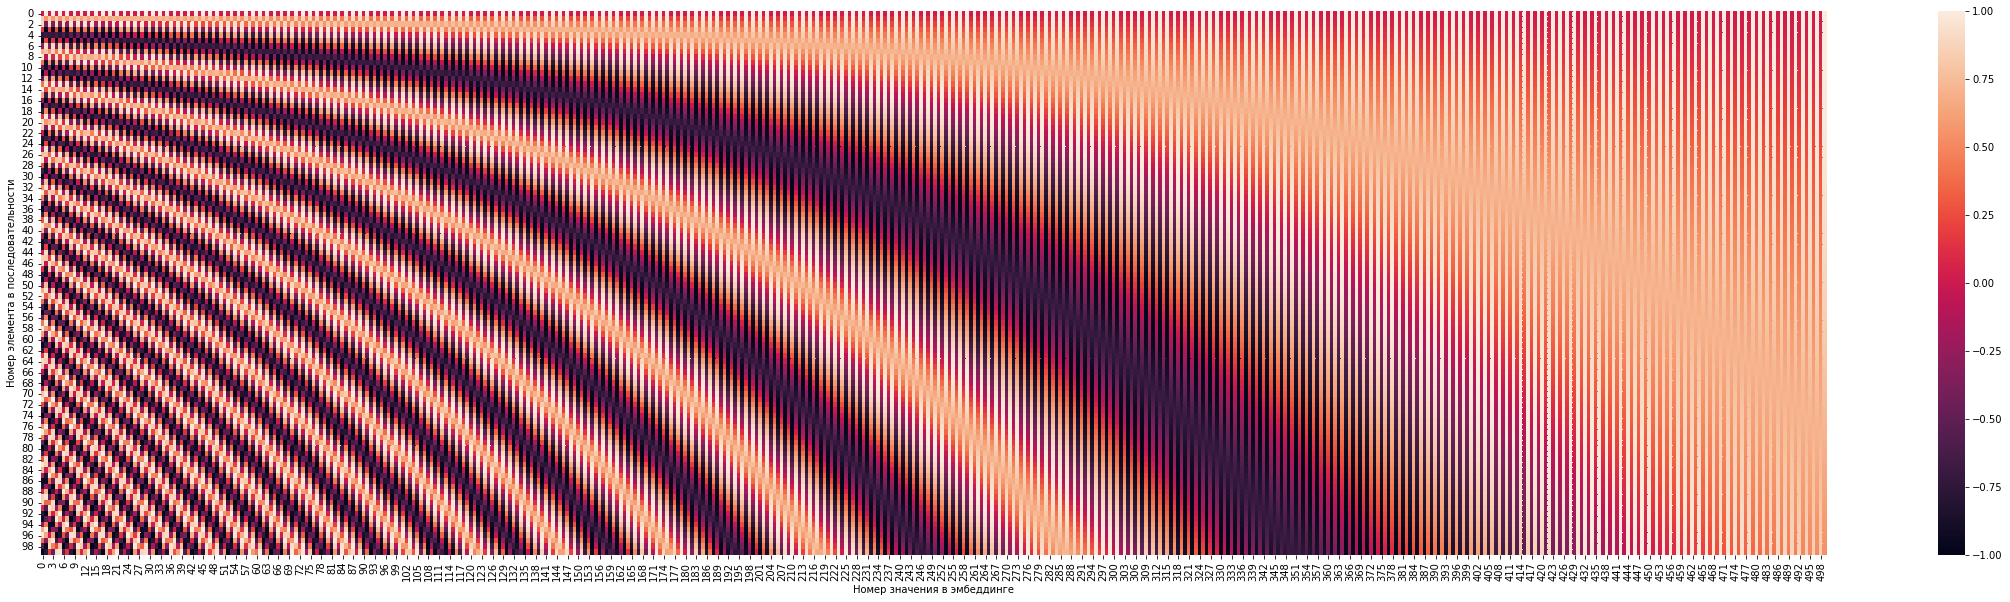

In [32]:
def test_positionalEncoding():
  batch_size, seq_len, d_model, max_len = 8, 100, 500, 1000
  input = torch.zeros((batch_size, seq_len, d_model))
  pe = PositionalEncoding(d_model, max_len)
  
  with torch.no_grad():
    output = pe(input)
  
  assert output.shape == input.shape

  f, _ = plt.subplots(figsize=(40, 10))
  ax = seaborn.heatmap(output[0, :, :])

  ax.set_ylabel('Номер элемента в последовательности')
  ax.set_xlabel('Номер значения в эмбеддинге')

test_positionalEncoding()

Если знать, как выглядит исходная heatmap этой зависимости, то можно понять, что класс работает как нужно.

### Masked MultiHeadAttention
Во-первых, MMHA состоит из нескольких блоков ScaledDotAttention (SDA).

Пусть матрица $X \in \mathbb{R}^{s×dim\_emb}$ является матрицей, представляющей какую-либо конкретную последовательность, где $s$ - размер последовательности, а $dim\_emb$ - размерность вектора, представляющего конкретный элемент в последовательности (будем считать, что вектор записывается в строчку а не в столбец).

При реализации ImageGPT нашим значением (в случае бинаризованного MNIST) $s$ - будет произведение размеров по ширине и высоте $(28*28=784)$ 

На вход в SDA подаются 3 матрицы 
$$K \in \mathbb{R}^{s \times kdim};$$
$$Q \in \mathbb{R}^{s \times kdim};$$
$$V \in \mathbb{R}^{s×vdim}.$$

Которые получаются путем перемножения матриц весов $W^K,W^Q \in \mathbb{R}^{dim\_emb×kdim}$, $W^V \in \mathbb{R}^{dim\_emb×vdim}$:

$$K = K_1W^K;$$
$$Q = Q_1W^Q;$$
$$V = V_1W^V.$$
где  $K_1, Q_1, V_1$ некоторые матрицы, имеющие размер $s×dim\_emb$ (дальше поймем почему это так).

Далее наши матрицы перемножаются по следующей формуле:
$$S = Softmax(\frac{QK^T}{\sqrt{kdim}}+M)V,$$
где $S \in \mathbb{R}^{s×s}$, а  $M \in \mathbb{R}^{s×s}$.

Давайте подробнее поговорим про матрицу $M$. Сама по себе эта матрица маски, которая в данном случае отвечает за авторегрессионность нашей модели. Эта маска имеет следующий вид:
$$
M = 
\begin{pmatrix}
0 & -∞ & -∞ & -∞ & ... & -∞ & -∞ \\
0 & 0 & -∞ & -∞ & ... & -∞ & -∞ \\
0 & 0 & 0 & -∞ & ... & -∞ & -∞ \\
... &  &  &  &  &  \\
0 & 0 & 0 & 0 & ... & -∞ & -∞\\
0 & 0 & 0 & 0 & ... & 0 & -∞
\end{pmatrix}
$$

Чтобы понять как она влияет на нашу авторегрессионность давайте сначала поймем что на самом деле содержиться в матрицы $K, V, Q$.

Изначально в SDA подаётся матрица $X$ и матрицам $K_1, V_1, Q_1$ присваиваются её значения.
При перемножении матриц весов мы получаем матрицы $K, Q, V$, на $i$-х строчках которых содержится какая-то информация о нашем $i$-ом элементе последовательности. При перемножении же матриц $K$ и $Q$ элемент $(i, j)$ начинает содержать некоторую информацию о связи $i$-го и $j-го$ векторов.
Для поддержания авторегрессионности нам важно, чтобы вектора с номером $i$ имел лишь информацию о векторе с номером $<i$ (тут мы считаем, что порядок правильный). Для этого мы и добавляем матрицу $M$. Давайте посмотрим что происходит:

$$S_b = \frac{QK^T}{\sqrt{kdim}} + M = \begin{pmatrix}
b_{1,1} & -∞ & -∞ & -∞ & ... & -∞ & -∞ \\
b_{2,1} & b_{2,2} & -∞ & -∞ & ... & -∞ & -∞ \\
b_{3,1} & b_{3,2} & b_{3,3} & -∞ & ... & -∞ & -∞ \\
... &  &  &  &  &  \\
b_{s-1,1} & b_{s-1,2} & b_{s-1,3} & b_{s-1,4} & ... & -∞ & -∞\\
b_{s,1} & b_{s,2} & b_{s,3} & b_{s,4} & ... & b_{s,s-1} & -∞
\end{pmatrix}
$$

Тогда применив функцию $Softmax$ к $S_b$ мы получим: 
$$S=Softmax(S_b) = 
\begin{pmatrix}
p_{1,1} & 0 & 0 & 0 & ... & 0 & 0 \\
p_{2,1} & p_{2,1} & 0 & 0 & ... & 0 & 0 \\
p_{3,1} & p_{3,1} & p_{3,1} & 0 & ... & 0 & 0 \\
... &  &  &  &  &  \\
p_{s-1,1} & p_{s-1,2} & p_{s-1,3} & p_{s-1,4} & ... & p_{s-1,s-1} & p_{s-1,s}\\
p_{s,1} & p_{s,2} & p_{s,3} & p_{s,4} & ... & p_{s,s-1} & p_{s,s}
\end{pmatrix}
$$

То есть в итоге, уможив матрицу $S$ на $V$ (каждая строка матрицы также содержит информацию о $i$-м элементе последовательности), в итоге мы получим:

$$
SV = \begin{pmatrix}
p_{1,1} & 0 & 0 & 0 & ... & 0 & 0 \\
p_{2,1} & p_{2,1} & 0 & 0 & ... & 0 & 0 \\
p_{3,1} & p_{3,1} & p_{3,1} & 0 & ... & 0 & 0 \\
... &  &  &  &  &  \\
p_{s-1,1} & p_{s-1,2} & p_{s-1,3} & p_{s-1,4} & ... & p_{s-1,s-1} & p_{s-1,s}\\
p_{s,1} & p_{s,2} & p_{s,3} & p_{s,4} & ... & p_{s,s-1} & p_{s,s}
\end{pmatrix}
\begin{pmatrix}
v_{1,1} & v_{1,2} & v_{1,3} & v_{1,4} & ... & v_{1,vdim-1} & v_{1,vdim} \\
v_{2,1} & v_{2,2} & v_{2,3} & v_{2,4} & ... & v_{2,vdim-1} & v_{2,vdim} \\
v_{3,1} & v_{3,2} & v_{3,3} & v_{3,4} & ... & v_{3,vdim-1} & v_{3,vdim} \\
... &  &  &  &  &  \\
v_{s-1,1} & v_{s-1,2} & v_{s-1,3} & v_{s-1,4} & ... & v_{s-1,vdim-1} & v_{s-1,vdim}\\
v_{s,1} & v_{s,2} & v_{s,3} & v_{s,4} & ... & v_{s,vdim-1} & v_{s,vdim}
\end{pmatrix}
$$



И в действительности, наша модель удовлетворяет авторегрессионному свойству.

Таких SDA блоков несколько (в нашем коде за это отвечает **num_heads**), при этом каждый из SDA блоков выдаёт информативное векторное представление $head_i \in  \mathbb{R}^{s×vdim}$, где $i$ соответствует конкретномум $i$-му SDA.

Далее все эти элементы объединяются $head = Concat(head_1, ..., head_{num\_heads}) \in \mathbb{R^{s×num\_heads*vdim}}$ и домнажаются на еще одну матрицу весов $W^O \in \mathbb{R^{num\_heads*vdim×dim\_emb}}$ в итоге на выходе получается:
$$
Z = head*W^O,
$$
где $Z \in \mathbb{R^{s × dim\_emb}}$ - матрица, содержащая информативные векторные представления относительно каждого элемента последовательности.

**В коде этот процесс выполняется при вызове экземпляра mla класса nn.MultiheadAttention, который располагается в классе DecoderBlock**

### Dropout

Перед тем, как вектор поступает на слой нормализации, к нему применяется механизм Dropout. Что собственно происходит?

Когда мы подаём элемент $x \in \mathbb{R^{d\_emb}}$, то с вероятностью p происходит зануление элементов входного вектора, а также происходит нормировка на $\frac{1}{p}$.

**На самом деле, Dropout тут был добавлен по ходу экспериментов, когда я пытался разобраться, почему у меня происходят проблемы с обучением модели**

###LayerNormalization

Перед тем, как данные пройдут через слой MMHA, они должны быть нормализованы. Это нужно для более быстрой сходимости модели.

Здесь просто происходит нормализация данных вдоль $i$-го вектора, который соответствует элементу последовательности $i$. По следующей формуле:

$$E(x_{i,j}) = \frac{1}{{d\_emb}}\sum_{j=1}^{d\_emb}x_{i,j};$$

$$σ(x_{i,j})^2 = \frac{1}{{d\_emb}}\sum_{j=1}^{d\_emb}(x_{i,j}-E(x_{i,j}))^2;$$

$$LN(x_{i,j})=\frac{x_{i,j} - E(x_{i,j})}{\sqrt{σ(x_{i,j})^2 - ϵ}},$$ 

где $x_i \in \mathbb{R^{d\_emb}}$ вектор соответствующий элементу последовательности, а именно $i$ указывает на номер элемента в последовательности (т.е. $i=\overline{1,s}$), а $j$ указывает на размерность эмбеддинга (т.е. $j=\overline{1,d\_emb}$), а $ϵ=0.5$ в нашей реализации.

###Code Decoder

In [11]:
class DecoderBlock(nn.Module):
  '''
  Decoder блок для GPT2.
  Masked MultiheadAttention в декодере используется с флагом batch_first = True
  Перед нормализацией происходит процесс Dropout.
  Args:
    Cмотреть реализацию torch.nn.MultiheadAttention
  '''
  def __init__(self, dim_emb, kdim, vdim, num_heads) -> None:
    super().__init__()
    self.mla = nn.MultiheadAttention(dim_emb, num_heads, kdim = kdim, vdim = vdim, batch_first = True)
    
    self.drop1 = nn.Dropout()
    self.drop2 = nn.Dropout()

    self.ln_1 = nn.LayerNorm(dim_emb)
    self.fc1 = nn.Sequential(nn.Linear(dim_emb, dim_emb * 4),
                             nn.GELU(),
                             nn.Linear(dim_emb*4, dim_emb))
    self.ln_2 = nn.LayerNorm(dim_emb)

    self.dim_emb = dim_emb

  '''
  
  Args:
    n - количество строк в матрице
    m - количество столбцов
  Return:
    Верхне-треугольная матрица размера nxm, над главной диагональю которой 
    распологаются матрицы со значениями (-torch.inf) (см. блок про MaskedMultiheadAttention)
  '''
  def create_mask(self, n, m):
    return torch.triu(torch.ones((n, m)) * (-torch.inf), diagonal = 1)
  
  '''
  
  Args:
    х - входной тензор, который должен иметь следующие значения (batch_size, sequence_length, dim_emb)
  Return:
    Кортеж из 2-х векторов, где:
    1) res - тензор с информативным векторным представлением нашей последовательности, 
    который имеет размер (batch_size, sequence_length, dim_emb)
    2) attn_weigth - матрица, реализующая авторегрессинность (в нашей выкладке
    это матрица после применения слоя softmax)
  '''
  
  def forward(self, x):
    seq_len = x.shape[-2]
    mask = self.create_mask(seq_len, seq_len).to(x.device)

    x_ln1 = self.ln_1(self.drop1(x))

    attn_x, attn_weights = self.mla(x_ln1, x_ln1, x_ln1, attn_mask = mask)
    
    x_sum = x + attn_x

    x_ln2 = self.ln_2(self.drop2(x_sum))

    res = x_sum + self.fc1(x_ln2)

    return res, attn_weights

In [12]:
def test_DecoderBlock():
  dm, dk, dv = 4, 4, 4
  model = DecoderBlock(dim_emb = dm, kdim = dk, vdim = dv, num_heads = 2)
  print(model.create_mask(5,5))
  bs, seq_len = 8, 8
  input = torch.zeros((bs, seq_len, dm))

  with torch.no_grad():
    output, attn_weights = model(input)

  assert len(output.shape) == 3
  assert output.shape == (bs, seq_len, dv)
  
  test_attn = attn_weights.clone()
  test_attn[attn_weights != 0] = 1
  test_attn_gt = torch.tril(torch.ones(attn_weights.shape))
  assert torch.all(test_attn == test_attn_gt) # проверяем, что матрица внимания является нижнетриугольной
  assert torch.all(attn_weights.sum(dim = -1) == 1.0) # проверяем, что элементы матрицы внимания вдоль каждой диагонали действительно равны единицы

test_DecoderBlock()

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])


GPT2 В этом случае включает в себя:
1. Получение эмбеддингов для входящей последовательности
2. Добавление фиктивного вектора (add_s)
3. Последовательный проход по всем DecoderBlock (выход предыдущего DecoderBlock передаётся на вход в последующий)
4. Применяет линеный слой в пространство размерности vocab (в нашем случае vocab=количество значений пикселя)

Можно было бы сделать, чтобы эмбеддинги была возможность получить извне, а не только через nn.Embeddings, но добавлять не хотелось, потому что не хотелось еще раз учить модельку (:

In [12]:
class GPT2(nn.Module):
    '''
    Args:
      n_layers:int - количество слоёв декодера
      max_pos_encoding: - максимальное возможное значение строки. (Используется
      при positional encodings), если последовательность будет большей размерности, то
      произойдет ошибка.
      Остальные аргументы смотреть в Decoder
    '''
    def __init__(self, n_layers = 2, dim_emb = 8, kdim = 8, vdim = 8, num_heads = 2, vocab = 2, max_pos_encoding = 784):
      super().__init__()
      self.vocab = vocab
      self.dim_emb = dim_emb

      self.to_emb = nn.Embedding(vocab, dim_emb)

      self.pos_encoding = PositionalEncoding(dim_emb, max_pos_encoding)

      self.decoders = nn.ModuleList()

      for _ in range(n_layers):
        self.decoders.append(DecoderBlock(dim_emb, kdim, vdim, num_heads))
      
      self.last_fc = nn.Linear(dim_emb, vocab, bias=False)

      self.sos = torch.nn.Parameter(torch.zeros(dim_emb))
      nn.init.normal_(self.sos) #такое распределение параметров для фиктивных переменных было взято из 2-го гитхаба в домашке 

    '''
    Функция, которая добавляет к входному вектору первый элемент.
    Это нужно для того, чтобы соблюсти свойство авторегрессионности, при добавлении
    маски. Тогда наш первый элемент в последовательности будет зависить от себя, но
    отношение к последовательности он не имеет, но при этом все оставшиеся будут зависить
    от этого первого элемента, но не от себя, а значит мы сохраним свойство авторегрессионности.
    Последний элемент последовательности, при этом, удаляется.
    Args:
      x - тензор, содержащий информативные векторные представления о последовательности,
      который должен иметь следующий размер (batch_size, sequence_length, self.dim_emb)
    Return:
      Возвращается тензор, где на первом месте в каждой последовательности стоит 
      вектор соответствующий фиктивному элементу последовательности, значения
      этого вектора распределены по нормальному закону.
      Размерность (batch_size, sequence_length, self.dim_emb)
    '''
    def add_s(self, x):
      s_value = torch.ones(1, x.shape[0], x.shape[-1], device = x.device) * self.sos
      s_value = s_value.permute(1, 0, 2)
      return torch.cat((s_value, x), dim = 1)[:, :-1, :]

    '''
    Args:
      X - тензор с данными, имеющий размеры (batch_size, seq_len)
    Return:
      Тензор размера (batch_size, seq_len, self.vocab),
    '''
    def forward(self, x):
      h = self.to_emb(x) # (batch_size, seq_len, self.dim_emb)
      h = self.add_s(h) # (batch_size, seq_len, self.dim_emb)
      h = self.pos_encoding(h)

      for decoder in self.decoders:
        h, aw= decoder(h) #(batch_size, seq_len, self.dim_emb)
      
      logits = self.last_fc(h) #(batch_size, seq_len, self.vocab)

      return logits



In [20]:
def test_gpt2_add_s():
  num_classes = 2
  bs, seq_len, emb_dim = 8, 8, 8
  
  input = torch.zeros((bs, seq_len, emb_dim))
  
  model = GPT2()

  gt = torch.ones((bs, emb_dim))
  
  sad = model.add_s(input)
  
  assert torch.allclose(sad[:, 0, :], model.sos)

def test_gpt2_forward():
  vocab = 2
  bs, seq_len, emb_dim = 8, 8, 8
  
  input = torch.zeros((bs, seq_len), dtype = torch.long)
  
  model = GPT2()

  with torch.no_grad():
    output = model(input)

  assert (bs, seq_len, vocab) == tuple(output.shape)

test_gpt2_add_s()
test_gpt2_forward()

In [22]:
class ImageGPT(nn.Module):
  '''
  Авторегрессионная модель на основе механизма внимания.
  Args:
    pscale:int - возможные значения пикселя
    input_shape:tuple - размер изображения
    num_decoders:
  '''
  def __init__(self,
               pscale = 2, 
               input_shape = (28, 28),
               num_decoders = 1,
               num_heads = 8,
               dim_emb = 512,
               kdim = 512,
               vdim = 512) -> None:
    super().__init__()
    self.gpt2 = GPT2(num_decoders, dim_emb, kdim, vdim, num_heads, pscale, input_shape[0]*input_shape[1])
    self.criterion = nn.CrossEntropyLoss()
    self.input_shape = input_shape
    self.pscale = pscale
  
  def forward(self, x):
    return self.gpt2(x) # (bs, input[0]*input[1], vocab_size)

  '''
  Args
    x - тензор с входными данными, который имеет размер (batch_size, sequence_length)
  Return:
    Словарь следующего вида:
    {
      "total_loss": значение cross entropy loss, которое нужно для оптимизации
    }
  '''
  def loss(self, x):
    x_pred = self.forward(x)
    x_pred = x_pred.permute(0, 2, 1) # нужно изменить размерность на (batch_size, self.pscale, sequence_length) дабы вычислить cross_entropy_loss
    total_loss = self.criterion(x_pred, x)

    #probas = nn.functional.softmax(x_pred, dim = 1)
    #s =  torch.multinomial(probas[:, 0, :], num_samples=1).squeeze(-1)
    return {'total_loss': total_loss}

  def sample(self, n):
        # read carefully the sampling process
        samples = torch.zeros(n, self.input_shape[0]*self.input_shape[1],  dtype = torch.long).to('cuda:0') # тут нужно было бы изменить и сделать смену девайса, но переписывать и переобучивать не хочется (:
        with torch.no_grad():
          for i in range(0, self.input_shape[0] * self.input_shape[1]):
            output = self(samples)
            logits =  output[:, i, :]
            probas = nn.functional.softmax(logits, dim = 1)
            samples[:, i] =  torch.multinomial(probas, num_samples=1).squeeze(-1)
        return samples.cpu().numpy().reshape(n, 1, *self.input_shape)
  


In [34]:
def test_imagegpt_forward():
  model = ImageGPT()
  bs, width, height = 8, 28, 28
  img = torch.zeros((bs, width * height), dtype = torch.long)
  with torch.no_grad():
    output = model(img)

def test_imagegpt_loss():
  model = ImageGPT()
  bs, width, height = 8, 28, 28
  img = torch.zeros((bs, width * height), dtype = torch.long)
  with torch.no_grad():
    loss_dict = model.loss(img)

  assert 'total_loss' in loss_dict
  assert isinstance(loss_dict['total_loss'], torch.Tensor)

def test_imagegpt_sampling():
  model = ImageGPT()
  bs, width, height = 8, 28, 28
  img = torch.zeros((bs, width * height), dtype = torch.long)
  samples = model.sample(1)
  show_samples(samples, title='MNIST samples', nrow=5)
  

test_imagegpt_forward()
test_imagegpt_loss()
test_imagegpt_sampling()

In [ ]:
torch.autograd.set_detect_anomaly(True)

In [ ]:
EPOCHS = 1
BATCH_SIZE = 16
LR = 1e-3 


model = ImageGPT(num_decoders = 8, num_heads = 8)

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(
    model, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    lr=LR, 
    use_tqdm=True, 
    use_cuda=True,
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
should_save = False

In [ ]:
if should_save:
  PATH = '/content/drive/MyDrive/ImageGPTCor2_Copy'
  torch.save(model.state_dict(), PATH)

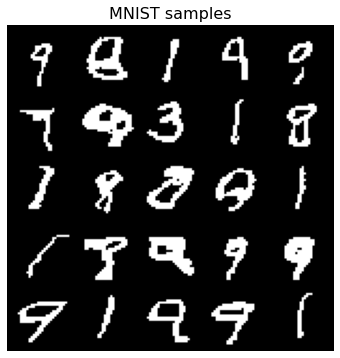

In [ ]:
samples = model.sample(25)
show_samples(samples, title='MNIST samples', nrow=5)

In [ ]:
should_load = False

In [15]:
if should_load:
  model = ImageGPT(num_decoders = 8, num_heads = 8)
  model.load_state_dict(torch.load('/content/drive/MyDrive/ImageGPTCor2_Copy'))

<All keys matched successfully>

In [ ]:
model.to(device = 'cuda:0')

In [59]:
sum(p.numel() for p in model.parameters())

25221632

In [31]:
'''
Для сэмплинга нужна cuda :(
Args:
  model:ImageGPT - исходная модель
  n:int -  количество сэмплов
  init: - тензор с изображениями размера (batch_size, sequence_length), где на
  месте, с которого нужно начинать сэмплировать и до последнего пикселя в изображении стоят единицы
'''
def auto_complete_sample(model, n, init, device = 'cuda:0'):
        s_pixel = int((init == -1).nonzero()[0, 1])
        init[init == -1] = 0
        samples = init.clone().to(device)

        with torch.no_grad():
          for i in range(s_pixel, model.input_shape[0] * model.input_shape[1]):
            output = model(samples)
            logits =  output[:, i, :]
            probas = nn.functional.softmax(logits, dim = 1)
            samples[:, i] =  torch.multinomial(probas, num_samples=1).squeeze(-1)
        return samples.cpu().numpy().reshape(n, 1, *model.input_shape)

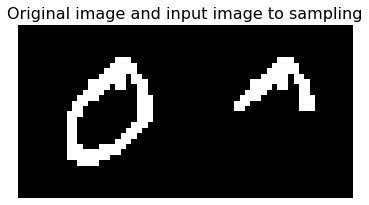

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:668.)
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1586.)
  This is separate from the ipykernel package so we can avoid doing imports until


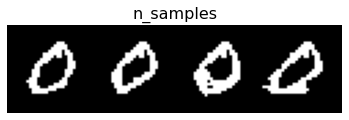

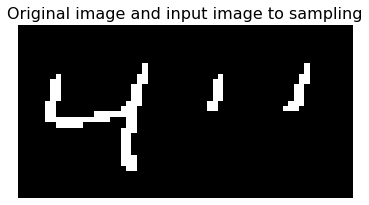

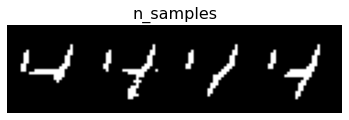

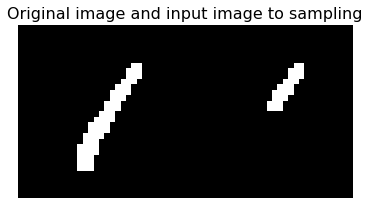

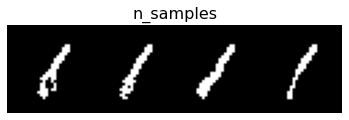

In [32]:
def autocomplete_image(image, model, n_samples):
    # Remove lower half of the image
    image_init = image.copy()
    image_init[image.shape[0] // 2:] = -1
    image = image.reshape((1, *model.input_shape))
    image_init = image_init.reshape((1, *model.input_shape))
    samples = np.stack([image, np.maximum(image_init, 0)])
    show_samples(samples, title="Original image and input image to sampling", nrow=2)
    # Generate completions

    image_init = torch.tensor(image_init, dtype = torch.long)
    image_init = image_init.unsqueeze(dim=0).expand(n_samples, -1, -1, -1)
    img_generated = auto_complete_sample(model, n_samples, image_init.reshape((image_init.shape[0], -1)))

    show_samples(img_generated, title="n_samples", nrow=4)
  
for i in range(1, 4):
    autocomplete_image(train_data[i], model, n_samples=4)